
**Install requirements**

**Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torch.autograd import Variable
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import alexnet, vgg16, resnet18, resnet50
from PIL import Image
from tqdm import tqdm
from torch.utils.data import random_split

**Set Arguments**

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 100    #num classes of CIFAR100

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.1      # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 0.0001  # Regularization, you can keep this at the default

NUM_EPOCHS = 160   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10000    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 100


**Define Data Preprocessing**

In [ ]:
NETWORK_TYPE = "resnet20"       #define which network we will use: alexnet, vgg, resnet18, resnet20...

FREEZING = "no_freezing"        # define which layers of the network will be kept frozen
                                # None : train the whole network
                                # "CONV" : train only the FC-layers
                                # "FC" : train only the conv-layers

**Trasformations**

In [ ]:
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], # pretrain on CIFR100
                                                           std=[0.229, 0.224, 0.225])
])

**Define Training set, validation set and testing**



In [ ]:

VAL_SIZE = 5000

#load training and testing
trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=train_transform)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True,transform=train_transform)


# print some statistics
classes = trainset.classes
class_count = {}
for _, index in trainset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
print(class_count)
print(f"classi totali: {len(class_count)}")


#retrive training and validation from training data
train_size = len(trainset) - VAL_SIZE
trainset, validset = random_split(trainset, [train_size, VAL_SIZE])


#load dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2, drop_last=True)

validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2, drop_last=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2, drop_last=True)

# Check dataset sizes
print('Train Dataset: {}'.format(len(trainset)))
print('Valid Dataset: {}'.format(len(validset)))
print('Test Dataset: {}'.format(len(testset)))


100%|██████████| 169001437/169001437 [00:01<00:00, 92633633.70it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
{'cattle': 500, 'dinosaur': 500, 'apple': 500, 'boy': 500, 'aquarium_fish': 500, 'telephone': 500, 'train': 500, 'cup': 500, 'cloud': 500, 'elephant': 500, 'keyboard': 500, 'willow_tree': 500, 'sunflower': 500, 'castle': 500, 'sea': 500, 'bicycle': 500, 'wolf': 500, 'squirrel': 500, 'shrew': 500, 'pine_tree': 500, 'rose': 500, 'television': 500, 'table': 500, 'possum': 500, 'oak_tree': 500, 'leopard': 500, 'maple_tree': 500, 'rabbit': 500, 'chimpanzee': 500, 'clock': 500, 'streetcar': 500, 'cockroach': 500, 'snake': 500, 'lobster': 500, 'mountain': 500, 'palm_tree': 500, 'skyscraper': 500, 'tractor': 500, 'shark': 500, 'butterfly': 500, 'bottle': 500, 'bee': 500, 'chair': 500, 'woman': 500, 'hamster': 500, 'otter': 500, 'seal': 500, 'lion': 500, 'mushroom': 500, 'girl': 500, 'sweet_pepper': 500, 'forest': 500, 'crocodile': 500, 'orange': 500, 'tulip': 500, 'mouse': 500, 'camel': 500, 'caterpillar'

**Show immages and classes of the dataset**

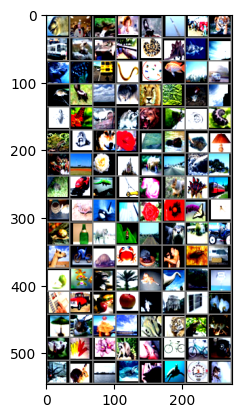

seal  man   mushroom girl  skunk rocket bus   tiger streetcar seal  tank  bridge snake dinosaur dolphin cloud shark skunk bus   worm  plate aquarium_fish mountain bus   mouse skunk plain wolf  lion  pine_tree snail cloud cockroach butterfly lizard raccoon lion  bicycle plate caterpillar shrew raccoon wolf  poppy otter beaver ray   lamp  lobster plain rose  castle dinosaur road  seal  oak_tree shrew lawn_mower lizard lawn_mower rose  squirrel dinosaur streetcar rabbit lizard whale skyscraper rose  poppy butterfly spider snail bottle elephant beetle plain otter house tractor camel bicycle beaver crab  porcupine man   cockroach couch pear  orchid chimpanzee palm_tree tiger dinosaur pine_tree cup   telephone pickup_truck apple apple shark house wardrobe orchid lamp  squirrel flatfish cloud ray   tiger lizard shrew tulip sweet_pepper orchid raccoon shark bicycle bicycle telephone spider rabbit sea   turtle shrew turtle plate raccoon


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

**Build resNet20**

In [ ]:
TYPE_OF_NORM = "group" #batch or group
NUM_GROUP = 2   #2,4,8
# GroupNorm takes number of groups to divide the channels in and the number of channels to expect in the input.

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, nonlinearity='relu')

#Define ResNet20

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if TYPE_OF_NORM == 'batch':
          self.bn1 = nn.BatchNorm2d(planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)
        else:
          self.gn1 = nn.GroupNorm(NUM_GROUP, planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
          self.gn2 = nn.GroupNorm(NUM_GROUP, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
          if TYPE_OF_NORM == 'batch':
            self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion * planes) )
          else:
            self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  nn.GroupNorm(NUM_GROUP, self.expansion * planes)  )

        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        out = self.conv1(x)
        if TYPE_OF_NORM == "batch":
          out = self.bn1(out)
        else:
          out = self.gn1(out)

        out = self.relu(out)
        out = self.conv2(out)

        if TYPE_OF_NORM == "batch":
          out = self.bn2(out)
        else:
          out = self.gn2(out)

        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)

        if TYPE_OF_NORM == 'batch':
          self.bn1 = nn.BatchNorm2d(16)
        else:
          self.gn1 = nn.GroupNorm(NUM_GROUP, 16)
        self.relu = nn.ReLU()

        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AvgPool2d(kernel_size=(8,8), stride=(1,1))
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)
        """for name, module in self.named_children():
          if name in ['conv2']:
            torch.nn.init.zeros_(module.weight)"""

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        if TYPE_OF_NORM == "batch":
          out = self.bn1(out)
        else:
          out = self.gn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.reshape(out.shape[0], -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

**Prepare Network**

In [ ]:
from torchvision import models
from torchsummary import summary
import torch
import torch.nn as nn

if NETWORK_TYPE == 'alexnet':
  net = alexnet(pretrained='imagenet')
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

elif NETWORK_TYPE == 'vgg':
  net = vgg16(pretrained='imagenet')
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

elif NETWORK_TYPE == 'resnet20':
  print("=> Loading ResNet20")
  net = resnet20()
  #summary(net.cuda(), (3,32,32))
  #print(net) #show details of resnet20

elif NETWORK_TYPE == 'resnet18':
  net = resnet18()
  #print(net) show details of resnet18

=> Loading ResNet20


**Prepare Training**

In [ ]:
SCHEDULER_TYPE = 'step' #step or cosine

# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize and which one to freeze
if (FREEZING == 'no_freezing'):
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif (FREEZING == 'conv_layers'):
  parameters_to_optimize = net.classifier.parameters() # Updates only fully-connected layers (no conv)
elif (FREEZING == 'fc_layers'):
  parameters_to_optimize = net.features.parameters() # Updates only conv layers (no fc)
else :
  raise (ValueError(f"Error Freezing layers (FREEZE = {FREEZING}) \n Possible values are: 'no_freezing', 'conv_layers', 'fc_layers' "))

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;)
#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
if SCHEDULER_TYPE == 'step':
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
else:
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=0.00001)

**Validation**

In [ ]:

def evaluate(net, dataloader, print_tqdm = True):
  with torch.no_grad():
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net.train(False) # Set Network to evaluation mode
    running_corrects = 0
    iterable = tqdm(dataloader) if print_tqdm else dataloader
    losses = []
    for images, labels in iterable:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      # Forward Pass
      outputs = net(images)
      loss = criterion(outputs, labels)
      losses.append(loss.item())
      # Get predictions
      _, preds = torch.max(outputs.data, 1)
      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
    # Calculate Accuracy
    accuracy = running_corrects / float(len(dataloader.dataset))

  return accuracy, mean(losses)

**Train**

In [ ]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0

val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in trainloader:

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    optimizer.zero_grad() # Zero-ing the gradients

    with torch.set_grad_enabled(True):
      # Forward pass to the network
      outputs = net(images)

      # Compute loss based on output and ground truth
      loss = criterion(outputs, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

     # Step the scheduler
    scheduler.step()
    current_step += 1

  train_acc, train_loss = evaluate(net, trainloader, print_tqdm = False)
  train_accuracies.append(train_acc)
  train_losses.append(train_loss)

  val_acc, val_loss = evaluate(net, validloader, print_tqdm = False)
  val_accuracies.append(val_acc)
  val_losses.append(val_loss)
  d = {"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss }



Starting epoch 1/160, LR = [0.1]
Step 0, Loss 6.2938232421875
Step 100, Loss 4.619812488555908
Step 200, Loss 4.613564491271973
Step 300, Loss 4.610569000244141
Starting epoch 2/160, LR = [0.1]
Step 400, Loss 4.589189052581787
Step 500, Loss 4.527225017547607
Step 600, Loss 4.539196491241455
Step 700, Loss 4.300054550170898
Starting epoch 3/160, LR = [0.1]
Step 800, Loss 4.0810651779174805
Step 900, Loss 4.149824142456055
Step 1000, Loss 3.9908294677734375
Starting epoch 4/160, LR = [0.1]
Step 1100, Loss 4.064395904541016
Step 1200, Loss 3.7079243659973145
Step 1300, Loss 3.7079317569732666
Step 1400, Loss 3.6568241119384766
Starting epoch 5/160, LR = [0.1]
Step 1500, Loss 3.740560531616211
Step 1600, Loss 3.6644811630249023
Step 1700, Loss 3.7227067947387695
Starting epoch 6/160, LR = [0.1]
Step 1800, Loss 3.565054416656494
Step 1900, Loss 3.3064143657684326
Step 2000, Loss 3.4798824787139893
Step 2100, Loss 3.598273992538452
Starting epoch 7/160, LR = [0.1]
Step 2200, Loss 3.49870753

**Test**

In [ ]:

accuracy, loss = evaluate(net, testloader)
print('\nTest Accuracy: {}'.format(accuracy))
print('\nTest Loss: {}'.format(loss))

100%|██████████| 78/78 [00:04<00:00, 19.34it/s]


Test Accuracy: 0.5259

Test Loss: 1.7563740932024443


In [ ]:
import os
os.mkdir('checkpoint')

In [ ]:

print("=> Saving checkpoint")
filename = 'checkpoint/resnet20_100'
torch.save(net.state_dict(),filename)

=> Saving checkpoint
